# Neural network from scratch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf

In [2]:
(X_train, Y_train), (X_test, Y_test)  = tf.keras.datasets.mnist.load_data(path="mnist.npz")

In [3]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

### Before beginning anything let's take a quick glance at what the model is supposed to recognize

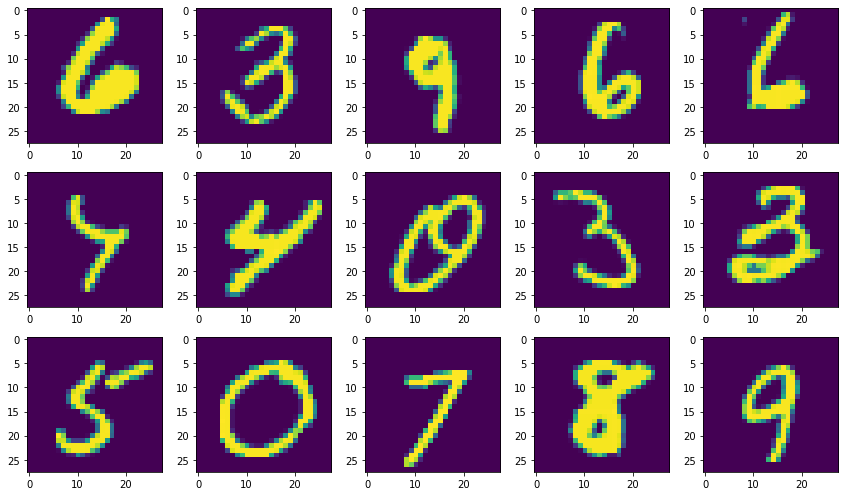

In [4]:
fig = plt.figure(figsize=(12,7))

for i in range(15): 
    
    fig.add_subplot(3,5, i+1) 
    plt.imshow(X_train[np.random.randint(X_train.shape[0])].reshape((28,28))) 
    fig.tight_layout()

plt.show()

# Implementation of deep learning

In [5]:
def classes_repartition(dataset):

    """Plot the classes repartition of the dataset"""

    unique, counts = np.unique(dataset, return_counts=True)
    unique = unique.astype(int)
    tmp = dict(zip(unique, counts))

    plt.bar(range(len(tmp)), list(tmp.values()), align='center')
    plt.xticks(range(len(tmp)), list(tmp.keys()))
    plt.title('Class repartion of our dataset')
    plt.xlabel('Class')
    plt.ylabel('Occurences in the dataset')


In [6]:
def test_train_split(X, Y, test_size = 0.2, shuffle = True):

    """Split and shuffle the dataset into train and test according to a size"""

    if shuffle :
        perm = np.random.permutation(X.shape[0])

        X = X[perm]
        Y = Y[perm]

    test_size = int(test_size * X.shape[0])
    
    X_test, Y_test = X[:test_size, :], Y[:test_size]
    X_train, Y_train = X[test_size:, :], Y[test_size:]

    return X_train, Y_train, X_test, Y_test

In [7]:
Y_labels = Y_train

In [8]:
def to_dummies(Y, nb_categories = 10) :

    """Perform one hot encoding on the labels"""

    new_Y = np.zeros((nb_categories, Y.shape[0]))

    Y[Y == nb_categories] = 0

    for i in range(Y.shape[0]):
        new_Y[int(Y[i]), i] = 1

    return new_Y

In [9]:
Y_train = to_dummies(Y_train)

In [10]:
def initialize_weights(dim_list, dictionary) :

    """Initialize the weights (not the bias) randomly to break symmetry (using the Xavier initialization)"""

    weights_list = []

    for layer in range(1, len(dim_list)) :

        weights_matrix = np.random.randn(dim_list[layer], dim_list[layer - 1]) * np.sqrt(1 / dim_list[layer - 1])
        dictionary["W" + str(layer)] = weights_matrix
        dictionary["momW"+str(layer)] = np.zeros(dictionary["W" + str(layer)].shape)

    return dictionary

In [11]:
def initialize_biases(dim_list, dictionary) :

    """Initialize the biases to zero"""

    for layer in range(1, len(dim_list)) :

        biases_vector = np.zeros((dim_list[layer], 1))
        dictionary["b" + str(layer)] = biases_vector
        dictionary["momb"+str(layer)] = np.zeros(dictionary["b" + str(layer)].shape)

    return dictionary

In [12]:
def initalization(dim_list, activation_list, lambdaa) :

    """Initialize wiehgts and biases and activation fucntion according to the architecture of the network"""

    dictionary = {}

    dictionary["nb_layers"] = len(dim_list)

    dictionary["lambda"] = lambdaa

    for i in range(len(activation_list)) :
        layer = i + 1
        dictionary["activation_"+str(layer)] = activation_list[i]

    dictionary = initialize_weights(dim_list, dictionary)
    dictionary = initialize_biases(dim_list, dictionary)

    return dictionary

In [13]:
def sigmoid(x) :

    """Apply sigmoid function"""
    
    return 1 / (1 + np.exp(-x)) 

In [14]:
def ReLU(x) :

    """Apply ReLU function"""

    return x * (x > 0)

In [15]:
def forward_propagation(matrix, dictionary) :

    """Compute the forward propagation"""

    nb_layers = dictionary["nb_layers"]

    results = matrix.T

    dictionary["A0"] = results
    
    for layer in range(1, nb_layers) :

        results = dictionary["W"+str(layer)] @ results + dictionary["b"+str(layer)]

        dictionary["Z"+str(layer)] = results
        
        if dictionary["activation_"+str(layer)] == "sigmoid" :
            results = sigmoid(results)
        
        else :
            results = ReLU(results)

        dictionary["A"+str(layer)] = results

    return dictionary


In [16]:
def compute_derivative(x, activation) :

    """Compute the derivative given the activation function"""

    if activation == "sigmoid" : 
        result = sigmoid(x) * (1 - sigmoid(x))

    else :
        flat = x.flatten()
        result = flat >= 0
        result = result.reshape(x.shape[0], x.shape[1])

    return result

In [17]:
def back_propagation(labels, dictionary) :

    """Compute the backward propagation"""

    nb_layers = dictionary["nb_layers"]

    lambdaa = dictionary["lambda"]

    m = dictionary["A"+str(nb_layers-2)].shape[1]

    error_gradient = dictionary["A"+str(nb_layers-1)] - labels
    dictionary["dW"+str(nb_layers-1)] = error_gradient @ dictionary["A"+str(nb_layers-2)].T / m + lambdaa * dictionary["W"+str(nb_layers-1)]
    dictionary["db"+str(nb_layers-1)] = np.sum(error_gradient, axis=1, keepdims=True) / m

    for layer in reversed(range(1, nb_layers-1)):

        error_gradient = dictionary["W"+str(layer+1)].T @ error_gradient * compute_derivative(dictionary["Z"+str(layer)], dictionary["activation_"+str(layer)])
        dictionary["dW"+str(layer)] = error_gradient @ dictionary["A"+str(layer-1)].T / m + lambdaa * dictionary["W"+str(layer)]
        dictionary["db"+str(layer)] = np.sum(error_gradient, axis=1, keepdims=True) / m

    return dictionary

In [18]:
def cost_function(dictionary, labels) :

    """Compute the cost fucntion"""

    predictions = dictionary["A"+str(dictionary["nb_layers"]-1)]

    lambdaa = dictionary["lambda"]

    m = predictions.shape[1]

    reg = 0

    if lambdaa != 0 :

        nb_layers = dictionary["nb_layers"]

        for layer in range(1, nb_layers - 1) :

            reg += np.sum(dictionary["W"+str(layer)])
        
        reg = lambdaa * reg

    return np.sum(- labels * np.log(predictions) - (1 - labels) * np.log(1 - predictions)) / m + reg

In [19]:
def update_weights(dictionary, learning_rate, mom) :

    """Update the weights according to gradients and a learning rate"""

    nb_layers = dictionary["nb_layers"]

    for layer in range(1, nb_layers) :
        update = mom * dictionary["momW"+str(layer)] + learning_rate * dictionary["dW"+str(layer)]
        dictionary["W"+str(layer)] -= update

    return dictionary

In [20]:
def update_biases(dictionary, learning_rate, mom):

    """Update the biases according to gradients and a learning rate"""

    nb_layers = dictionary["nb_layers"]

    for layer in range(1, nb_layers) :
        update = mom * dictionary["momb"+str(layer)] + learning_rate * dictionary["db"+str(layer)]
        dictionary["b"+str(layer)] -= update

    return dictionary

In [21]:
def get_minibatches(X, Y, batch_size) :

    """Return all the minibatches in order to perform mini-batch gradient descent"""
    
    X_minibatches = []
    Y_minibatches = []

    m = X.shape[0]

    perm = np.random.permutation(m)

    X = X[perm]
    Y = Y[:,perm]

    remainder = 0

    if m % batch_size != 0 :
        remainder = 1

    for i in range(m // batch_size + remainder) :
        
        if i == m // batch_size :

            X_minibatches.append(X[i * batch_size :])
            Y_minibatches.append(Y[:, i * batch_size :])

        else :

            X_minibatches.append(X[i * batch_size : (i + 1) * batch_size])
            Y_minibatches.append(Y[:, i * batch_size : (i + 1) * batch_size])


    return X_minibatches, Y_minibatches

In [22]:
def learning_rate_decay(learning_rate, epochs, decay) :

    """Compute the new learning rate according to an epoch and the old learning rate"""

    return learning_rate * np.exp(decay * epochs)

In [23]:
def fit(matrix, labels, dim_list, activation_list, epochs, learning_rate, lambdaa, batch_size, decay, mom, cost=True) :

    """Train a neural network according to a dataset and hyperparameters"""
    
    cost_list = []

    dictionary = initalization(dim_list, activation_list, lambdaa)

    for epoch in range(epochs) :

        learning_rate = learning_rate_decay(learning_rate, epoch, decay)

        X_minibatches, Y_minibatches = get_minibatches(matrix, labels, batch_size)

        for i in range(len(X_minibatches)) :

            X_mini, Y_mini = X_minibatches[i], Y_minibatches[i]

            dictionary = forward_propagation(X_mini, dictionary)

            if cost :
                cost_list.append(cost_function(dictionary, Y_mini))

            dictionary = back_propagation(Y_mini, dictionary)

            dictionary = update_weights(dictionary, learning_rate, mom)

            dictionary = update_biases(dictionary, learning_rate, mom)

    return dictionary, cost_list

### Let's normalize our data

In [24]:
X_train, X_test = X_train / 255, X_test / 255

#### Let's now look at the classes repartition in the training set

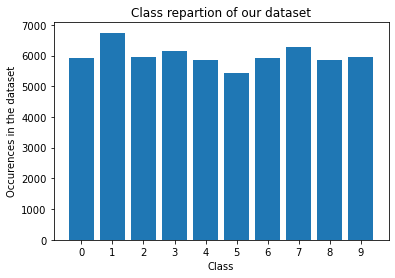

In [25]:
Y_labels[Y_labels == 10] = 0

classes_repartition(Y_labels)

#### As we can see, the classes are evenly distributed with 500 occurrences for each of the classes

# Training of the model

#### First let's define our hyperparameters which I found to be the best via hyperparameters tuning

In [26]:
dim_list = [784, 1200, 500, 200, 10]
activation_list = ["relu", "relu", "relu", "sigmoid"]
epochs = 15
learning_rate = 0.1
lambdaa = 0
batch_size = 32
decay = -0.001
mom = 0.9

#### The model is based on a mini-batch gradient descent using regularization, momentum and learning rate decay

In [27]:
dictionary, cost_list = fit(X_train, Y_train, dim_list, activation_list, epochs, learning_rate, lambdaa, batch_size, decay, mom)

<ipython-input-18-86c7de4d52fe>:23: RuntimeWarning: divide by zero encountered in log
  return np.sum(- labels * np.log(predictions) - (1 - labels) * np.log(1 - predictions)) / m + reg
<ipython-input-18-86c7de4d52fe>:23: RuntimeWarning: invalid value encountered in multiply
  return np.sum(- labels * np.log(predictions) - (1 - labels) * np.log(1 - predictions)) / m + reg


#### Now let's look at how the cost has behaved during the trainig of the model

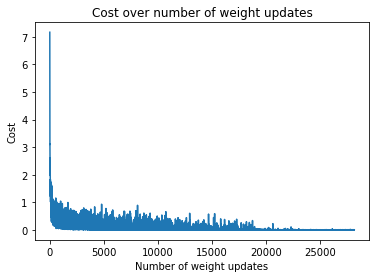

In [28]:
plt.title("Cost over number of weight updates")
plt.xlabel("Number of weight updates")
plt.ylabel("Cost")
plt.plot(cost_list)

#### We can first see that the cost drops really fast only to stabilize with the growing number of updates, then we notice that this growing number also reduce/remove the "noise"

# Metrics

In [29]:
predictions = forward_propagation(X_train, dictionary)

predictions = predictions["A"+str(dictionary["nb_layers"]-1)]

predictions = predictions.argmax(axis=0)

Y_labels = Y_labels.flatten()

accuracy = 100 * len((predictions - Y_labels)[predictions - Y_labels == 0.0]) / Y_labels.shape[0]

print("Accuracy on the training set :",accuracy,"%")

Accuracy on the training set : 100.0 %


In [30]:
predictions_test = forward_propagation(X_test, dictionary)

predictions_test = predictions_test["A"+str(dictionary["nb_layers"]-1)]

predictions_test = predictions_test.argmax(axis=0)

Y_test[Y_test == 10] = 0

Y_test = Y_test.flatten()

accuracy = 100 * len((predictions_test - Y_test)[predictions_test - Y_test == 0.0]) / Y_test.shape[0]

print("Accuracy on the test set :",accuracy,"%")

Accuracy on the test set : 98.63 %


In [31]:
def metrics_class(predictions_class, labels_class, string_class) :

    print("Those performances are evaluated on the test set")

    tp = len(labels_class[labels_class + predictions_class == 2])
    fn = len(labels_class[labels_class - predictions_class == 1])
    tn = len(predictions_class[predictions_class == 0]) - fn
    fp = len(predictions_class[predictions_class == 1]) - tp

    acc = (tp + tn) / (tp + tn + fn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * prec * recall / (prec + recall)

    cm = pd.DataFrame({ 'Not Predicted '+string_class: [str(tn)+' True Negatives',str(fn)+' False Negatives'],
                        'Predicted '+string_class: [str(fp)+' False Positives', str(tp)+' True Positives']},
                        index=['Not '+string_class,'Actual '+string_class])

    print("Accuracy on "+string_class+" :",acc)
    print("Precision on "+string_class+" :",prec)
    print("Recall on "+string_class+" :",recall)
    print("F1 score on "+string_class+" :",f1)
    print()
    print("Confusion matrix on "+string_class+" : ")
    print(cm)
        

In [32]:
def ROC_AUC_class(predictions_class, labels_class, string_class):

    base = [i for i in np.arange(0,1.01,0.01)]

    roc_1, roc_2, _ = roc_curve(labels_class, predictions_class)
    plt.plot(roc_1, roc_2, linestyle='--', label='The model')
    plt.plot(base, base, label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve for the class "+string_class )
    plt.legend()
    plt.show()

    auc_score = roc_auc_score(labels_class, predictions_class)
    print()
    print("AUC score of the class "+string_class+" :",auc_score)

In [33]:
def all_metrics_class(predictions_class, labels_class, probas_class, string_class) :

    metrics_class(predictions_class, labels_class, string_class)
    ROC_AUC_class(probas_class, labels_class, string_class)

In [34]:
predictions_labels = {}

predictions = forward_propagation(X_test, dictionary)

predictions = predictions["A"+str(dictionary["nb_layers"]-1)]

predictions_probas = predictions

predictions = predictions.argmax(axis=0)

Y_test[Y_test == 10] = 0

for i in range(10):

    predictions_labels["predictions_"+str(i)] = (predictions == i).astype(int)
    predictions_labels["labels_"+str(i)] = (Y_test == i).flatten().astype(int)
    predictions_labels["probas_"+str(i)] = predictions_probas[i, :]

# Metrics by class

#### Plot of a confusion matrix and a ROC curve for each of the classes 

Those performances are evaluated on the test set
Accuracy on 0 : 0.998
Precision on 0 : 0.9887983706720977
Recall on 0 : 0.9908163265306122
F1 score on 0 : 0.9898063200815495

Confusion matrix on 0 : 
              Not Predicted 0         Predicted 0
Not 0     9009 True Negatives  11 False Positives
Actual 0    9 False Negatives  971 True Positives


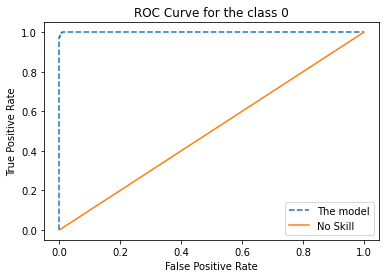


AUC score of the class 0 : 0.9999404950450247


In [35]:
i = 0

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 1 : 0.9986
Precision on 1 : 0.9929639401934917
Recall on 1 : 0.9947136563876652
F1 score on 1 : 0.9938380281690141

Confusion matrix on 1 : 
              Not Predicted 1          Predicted 1
Not 1     8857 True Negatives    8 False Positives
Actual 1    6 False Negatives  1129 True Positives


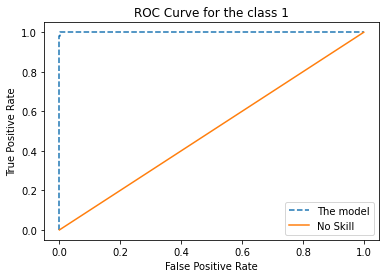


AUC score of the class 1 : 0.9999666062896457


In [36]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 2 : 0.9968
Precision on 2 : 0.9835589941972921
Recall on 2 : 0.9854651162790697
F1 score on 2 : 0.9845111326234268

Confusion matrix on 2 : 
              Not Predicted 2          Predicted 2
Not 2     8951 True Negatives   17 False Positives
Actual 2   15 False Negatives  1017 True Positives


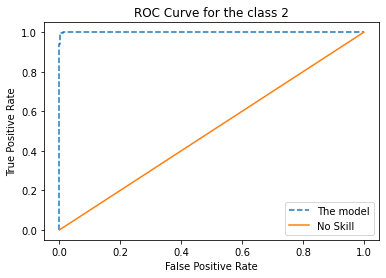


AUC score of the class 2 : 0.9998948673664848


In [37]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 3 : 0.9968
Precision on 3 : 0.983201581027668
Recall on 3 : 0.9851485148514851
F1 score on 3 : 0.9841740850642928

Confusion matrix on 3 : 
              Not Predicted 3         Predicted 3
Not 3     8973 True Negatives  17 False Positives
Actual 3   15 False Negatives  995 True Positives


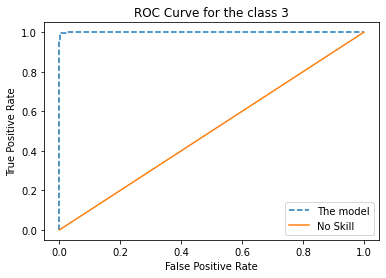


AUC score of the class 3 : 0.999833808742387


In [38]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 4 : 0.9968
Precision on 4 : 0.9866803278688525
Recall on 4 : 0.9806517311608961
F1 score on 4 : 0.9836567926455567

Confusion matrix on 4 : 
              Not Predicted 4         Predicted 4
Not 4     9005 True Negatives  13 False Positives
Actual 4   19 False Negatives  963 True Positives


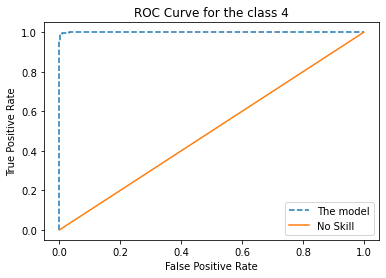


AUC score of the class 4 : 0.999644408851453


In [39]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 5 : 0.9981
Precision on 5 : 0.9943374858437146
Recall on 5 : 0.984304932735426
F1 score on 5 : 0.9892957746478874

Confusion matrix on 5 : 
              Not Predicted 5         Predicted 5
Not 5     9103 True Negatives   5 False Positives
Actual 5   14 False Negatives  878 True Positives


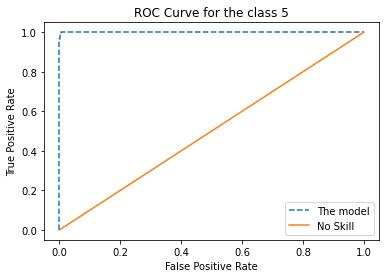


AUC score of the class 5 : 0.9999309482030285


In [40]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 6 : 0.9976
Precision on 6 : 0.9874739039665971
Recall on 6 : 0.9874739039665971
F1 score on 6 : 0.9874739039665971

Confusion matrix on 6 : 
              Not Predicted 6         Predicted 6
Not 6     9030 True Negatives  12 False Positives
Actual 6   12 False Negatives  946 True Positives


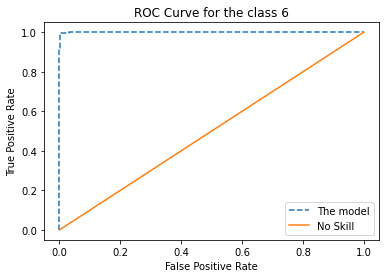


AUC score of the class 6 : 0.999637506990112


In [41]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 7 : 0.9968
Precision on 7 : 0.983495145631068
Recall on 7 : 0.9854085603112841
F1 score on 7 : 0.9844509232264333

Confusion matrix on 7 : 
              Not Predicted 7          Predicted 7
Not 7     8955 True Negatives   17 False Positives
Actual 7   15 False Negatives  1013 True Positives


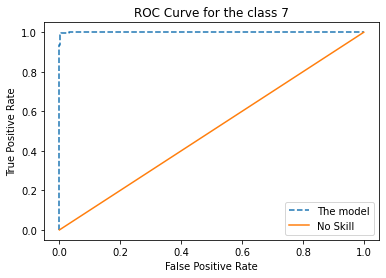


AUC score of the class 7 : 0.9997948654785923


In [42]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 8 : 0.997
Precision on 8 : 0.98659793814433
Recall on 8 : 0.9825462012320328
F1 score on 8 : 0.9845679012345678

Confusion matrix on 8 : 
              Not Predicted 8         Predicted 8
Not 8     9013 True Negatives  13 False Positives
Actual 8   17 False Negatives  957 True Positives


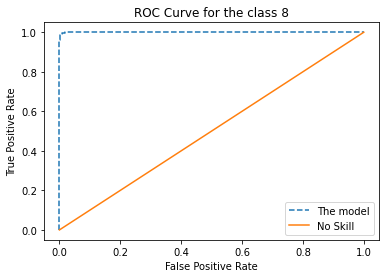


AUC score of the class 8 : 0.9998192536186814


In [43]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

Those performances are evaluated on the test set
Accuracy on 9 : 0.9961
Precision on 9 : 0.9764243614931237
Recall on 9 : 0.9851337958374629
F1 score on 9 : 0.9807597434632462

Confusion matrix on 9 : 
              Not Predicted 9         Predicted 9
Not 9     8967 True Negatives  24 False Positives
Actual 9   15 False Negatives  994 True Positives


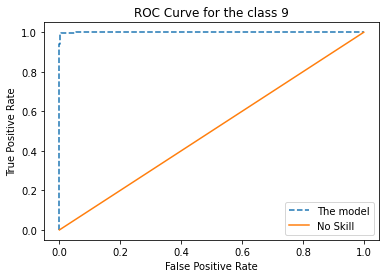


AUC score of the class 9 : 0.9996718445127211


In [44]:
i += 1

all_metrics_class(predictions_labels["predictions_"+str(i)], predictions_labels["labels_"+str(i)], predictions_labels["probas_"+str(i)], str(i))

#### We can see that for each of the classes we have a AUC score of at least 0.99.
#### We can note that the worst of our classes is the 2 where we have only 15 falsely predicted result out of 500.

# Analysis of the mislabeled examples

In [45]:
import numpy.ma as ma

predictions = forward_propagation(X_test, dictionary)

predictions = predictions["A"+str(dictionary["nb_layers"]-1)]

predictions = predictions.argmax(axis=0)

mask = predictions != Y_test.flatten()

mislabeled = X_test[mask, :]
mis_labels = predictions[mask]

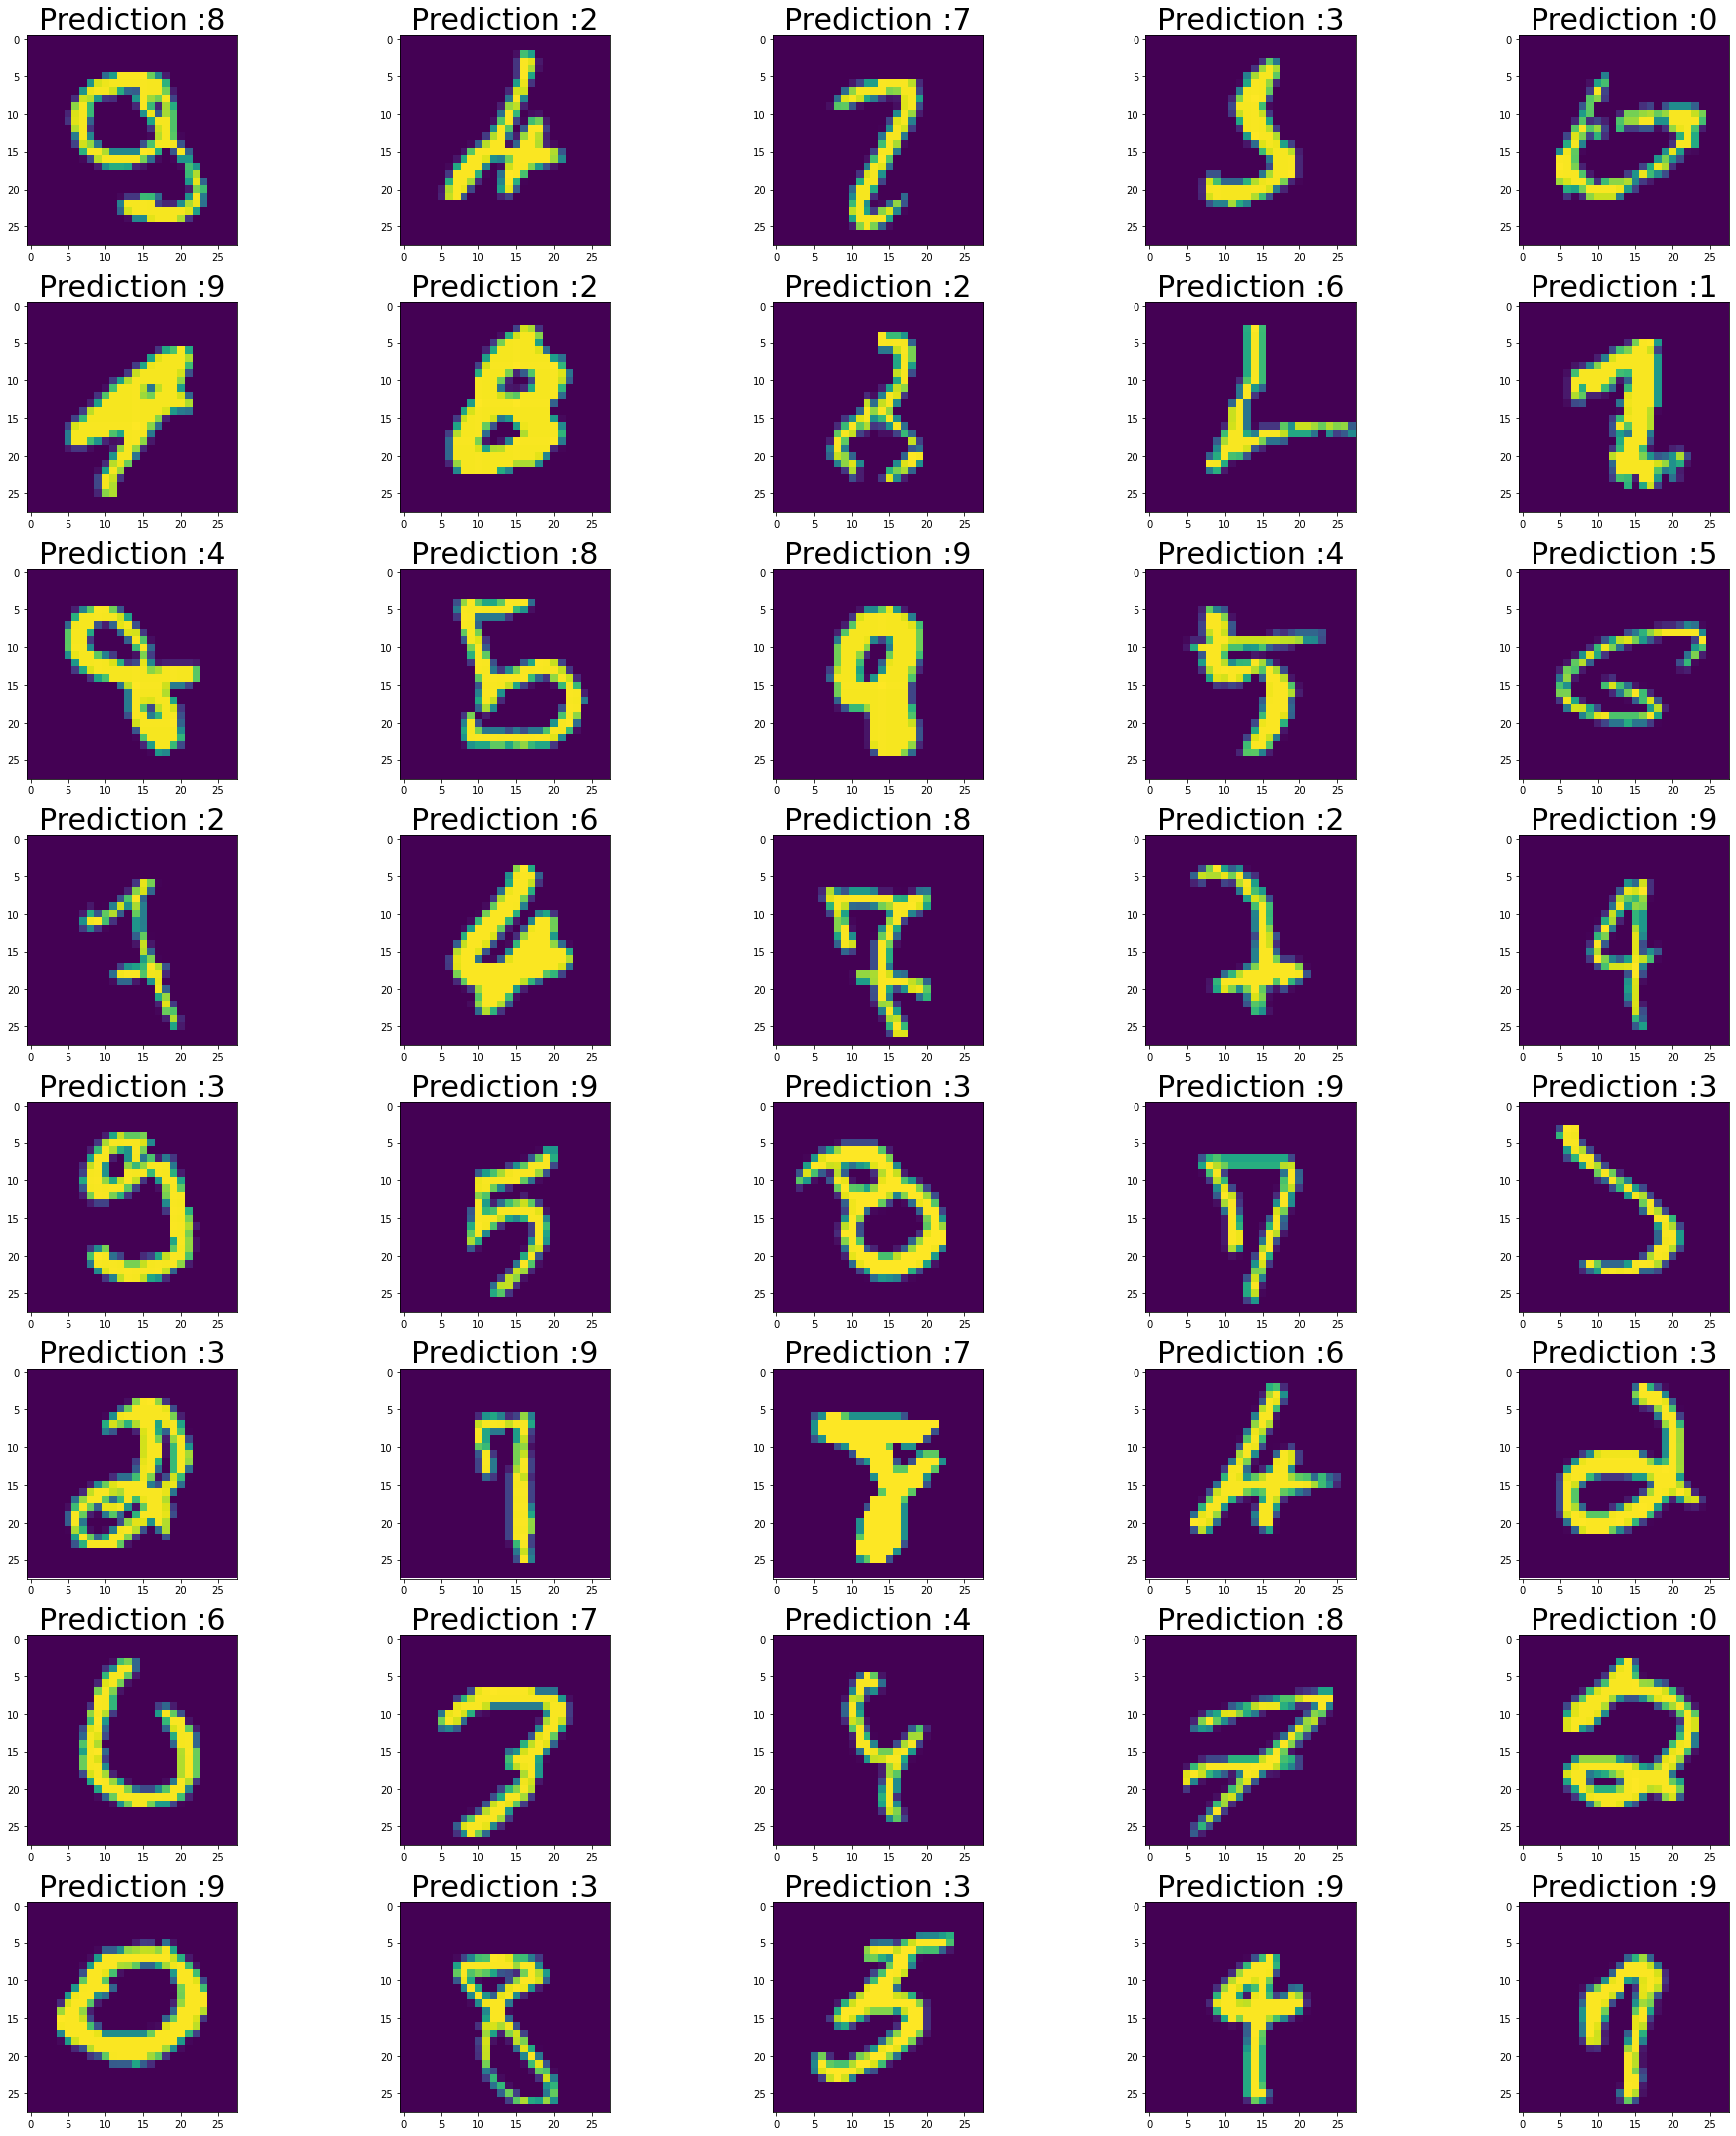

In [46]:
fig = plt.figure(figsize=(50,35))
fig.set_figheight(30)
fig.set_figwidth(30)
number_plots = mislabeled.shape[0]

plt.rcParams['axes.titlesize'] = 30

for i in range(40):
    ax = fig.add_subplot(8, 5, i+1)
    plt.imshow(mislabeled[i].reshape((28,28)))
    ax.title.set_text("Prediction :"+str(mis_labels[i]))
    fig.tight_layout()

plt.show()

# Impact of the number of layers

#### Let's compare performances of our model with the same number of nodes but a different number of layers.

In [47]:
archi = {}

archi["3_layers"] = [784, 1500, 10]
archi["4_layers"] = [784, 750, 750, 10]
archi["5_layers"] = [784, 500, 500, 500, 10]
archi["6_layers"] = [784, 400, 400, 400, 300, 10]
archi["7_layers"] = [784, 300, 300, 300, 300, 300, 10]
archi["8_layers"] = [784, 250, 250, 250, 250, 250, 250, 10]
archi["9_layers"] = [784, 215, 215, 215, 215, 215, 215, 210, 10]
archi["10_layers"] = [784, 180, 180, 180, 180, 180, 180, 180, 60, 10]
archi["11_layers"] = [784, 180, 160, 160, 160, 160, 160, 160, 160, 160, 10]
archi["12_layers"] = [784, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 10]
archi["13_layers"] = [784, 150, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135,10]
archi["14_layers"] = [784, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 10]
archi["15_layers"] = [784, 120, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 10]
archi["16_layers"] = [784, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 100, 100, 100, 100, 10]
archi["17_layers"] = [784, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10]

In [48]:
epochs = 12
learning_rate = 0.1
lambdaa = 0.001
batch_size = 64
decay = -0.001
mom = 0.90

In [49]:
nb_layers = [i for i in range(3, 18)]
acc_train = []
acc_test = []

for i in nb_layers :

    activation_list = ["relu" for j in range(len(archi[str(i)+"_layers"]) - 2)] + ["sigmoid"]
    dictionary,_ = fit(X_train, Y_train, archi[str(i)+"_layers"], activation_list, epochs, learning_rate, lambdaa, batch_size, decay, mom, False)

    predictions_train = forward_propagation(X_train, dictionary)
    predictions_train = predictions_train["A"+str(dictionary["nb_layers"]-1)]
    predictions_train = predictions_train.argmax(axis=0)

    accuracy_train = 100 * len(predictions_train[predictions_train - Y_labels == 0.0]) / Y_labels.shape[0]

    acc_train.append(accuracy_train)

    predictions_test = forward_propagation(X_test, dictionary)
    predictions_test = predictions_test["A"+str(dictionary["nb_layers"]-1)]
    predictions_test = predictions_test.argmax(axis=0)

    accuracy_test = 100 * len(predictions_test[predictions_test - Y_test == 0.0]) / Y_test.shape[0]

    acc_test.append(accuracy_test)


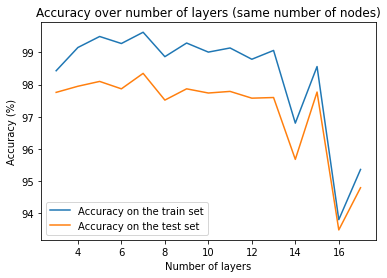

In [50]:
plt.rcParams['axes.titlesize'] = 12
plt.title("Accuracy over number of layers (same number of nodes)")
plt.xlabel("Number of layers")
plt.ylabel("Accuracy (%)")
plt.plot(nb_layers, acc_train, label="Accuracy on the train set")
plt.plot(nb_layers, acc_test, label="Accuracy on the test set")
plt.legend()

#### As we can see more layers doesnt necessarily mean better but quite the contrary, it seems the ideal number of layers for our model is between 4 and 7
#### It seems that the higher number of layers, the higher bias and lesser variance we have

# Comparison with Keras

In [51]:
Y_test = to_dummies(Y_test, nb_categories = 10)

In [52]:
from keras.layers import Input, Add, Dense
from keras.models import Sequential
import tensorflow as tf

model = Sequential()

model.add(Dense(units=784))
model.add(Dense(units=1200, activation='relu'))
model.add(Dense(units=500, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=10, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

hist = model.fit(X_train, Y_train.T, epochs = 8, verbose=1, batch_size=16, validation_data=(X_test, Y_test.T))

Epoch 1/8
3750/3750 [==============================] - 26s 7ms/step - loss: 0.3138 - acc: 0.9123 - val_loss: 0.2684 - val_acc: 0.9298
Epoch 2/8
3750/3750 [==============================] - 26s 7ms/step - loss: 0.1934 - acc: 0.9494 - val_loss: 0.1589 - val_acc: 0.9616
Epoch 3/8
3750/3750 [==============================] - 26s 7ms/step - loss: 0.1681 - acc: 0.9572 - val_loss: 0.1798 - val_acc: 0.9571
Epoch 4/8
3750/3750 [==============================] - 26s 7ms/step - loss: 0.1677 - acc: 0.9590 - val_loss: 0.1955 - val_acc: 0.9581
Epoch 5/8
3750/3750 [==============================] - 26s 7ms/step - loss: 0.1636 - acc: 0.9628 - val_loss: 0.1774 - val_acc: 0.9613
Epoch 6/8
3750/3750 [==============================] - 26s 7ms/step - loss: 0.1605 - acc: 0.9635 - val_loss: 0.1837 - val_acc: 0.9588
Epoch 7/8
3750/3750 [==============================] - 26s 7ms/step - loss: 0.1446 - acc: 0.9649 - val_loss: 0.1983 - val_acc: 0.9543
Epoch 8/8
3750/3750 [==============================] - 26s 7ms

#### It seems that the model has similar yet slighty better results than keras, but obviously where keras trades accuracy it give up speed